In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks in images from prompts with SAM 2

Segment Anything Model 2 (SAM 2) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SAM2ImagePredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [5]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

## Example image

In [160]:
image = Image.open('../../Datasets/blades_and_skins/third_one.jpg')
image = np.array(image.convert("RGB"))

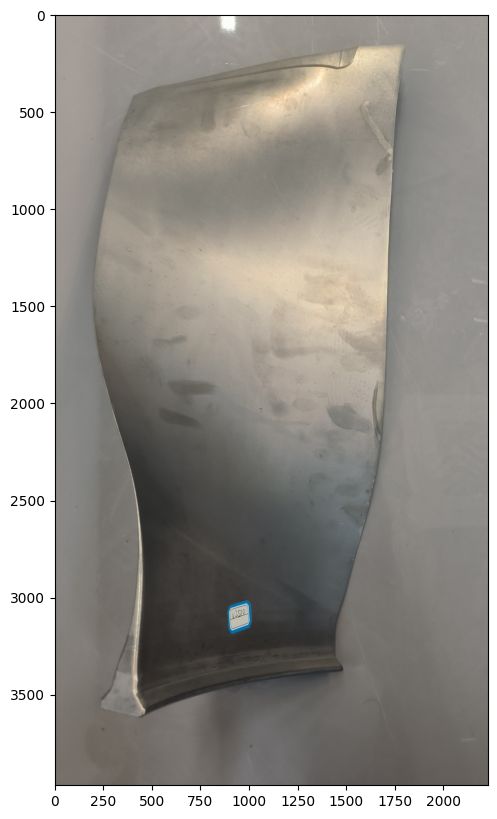

In [161]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM 2

First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.

In [162]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

Process the image to produce an image embedding by calling `SAM2ImagePredictor.set_image`. `SAM2ImagePredictor` remembers this embedding and will use it for subsequent mask prediction.

In [163]:
predictor.set_image(image)

## Batched prompt inputs

`SAM2ImagePredictor` can take multiple input prompts for the same image, using `predict` method. For example, imagine we have several box outputs from an object detector.

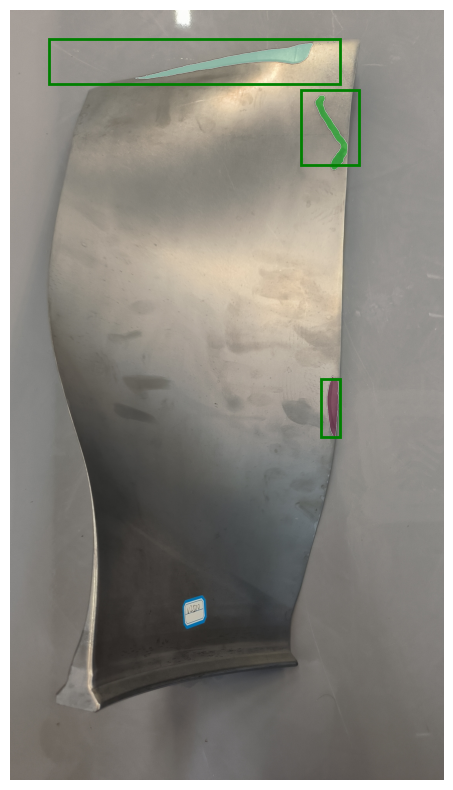

In [171]:
# # blades and skins image 1.jpg
# input_boxes = np.array([
#     [5, 10,105, 90],
#     [78, 45,90, 55],
# ])

# # blades and skins image 11.jpg
# input_boxes = np.array([
#     [25, 40,115, 110],
#     [25, 40,115, 110],
# ])

# # blades and skins image 26.jpg
# input_boxes = np.array([
#     [50, 40,120, 175],
#     [50, 40,120, 175],
# ])

# # blades and skins image 28.jpg
# input_boxes = np.array([
#     [20, 25,40, 40],
#     [20, 25,40, 40],
# ])

# # blades and skins image 32.jpg
# input_boxes = np.array([
#     [75, 25,125, 200],
#     [75, 25,125, 200],
# ])

# # blades and skins image 1021_2.jpg
# input_boxes = np.array([
#     [1600, 2100, 1900, 2300],
#     [1100, 3200, 1600, 3400],
# ])

# # blades and skins image 1021_3.jpg
# input_boxes = np.array([
#     [600, 1700, 1100, 2000],
#     [1100, 2800, 1600, 3400],
#     [500, 2100, 700, 2500],
#     [1100, 1700, 1600, 2500],
#     [500, 3100, 1200, 3600],   
# ])

# # blades and skins image 1021_5.jpg
# input_boxes = np.array([
#     [600, 3200, 1300, 3400],
#     [1400, 2000, 1800, 2300],  
# ])

# # blades and skins image forth_one.jpg
# input_boxes = np.array([
#     [400, 200, 1700, 600],
#     [1400, 2000, 1800, 2400],
#     [1400, 1500, 1700, 1800],  
# ])

# # blades and skins image third_one.jpg
input_boxes = np.array([
    [200, 150, 1700, 380],
    [1600, 1900, 1700, 2200],
    [1500, 410, 1800, 800],  
])

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
# plt.axis('off')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/third_one_only_masks.png')
for box in input_boxes:
    show_box(box, plt.gca())
# plt.savefig('../../Datasets/blades_and_skins_processed_data/1_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/11_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/26_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/28_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/32_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/1021_2_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/1021_3_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/1021_5_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/forth_one_processed.png')
# plt.savefig('../../Datasets/blades_and_skins_processed_data/third_one_processed.png')
plt.show()

Similarly, we can have a batch of point prompts defined over a single image

In [165]:
# # Input points and labels for the image
# image_pts = np.array([
#     [[90, 160]],
#     [[220, 110]],
#     [[145, 270]],
# ])
# image_labels = np.array([[1], [1], [1]])

# # Predict the masks and scores
# masks, scores, _ = predictor.predict(
#     point_coords=image_pts,
#     point_labels=image_labels,
#     multimask_output=True
# )

# # Select the best single mask per object
# best_mask = masks[range(len(masks)), np.argmax(scores, axis=-1)]

# # Visualize the results
# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# for mask in best_mask:
#     show_mask(mask, plt.gca(), random_color=True)
# show_points(image_pts, image_labels, plt.gca())
# plt.show()